In [321]:
from pyspark.sql import SparkSession

### Create a spark session

In [322]:
spark=SparkSession.builder.appName('Dataframe').getOrCreate()

### Schema for loading the data

In [323]:
from pyspark.sql.types import  (StructType, 
                                StructField, 
                                DateType, 
                                BooleanType,
                                DoubleType,
                                IntegerType,
                                StringType,
                               TimestampType)


crimes_schema = StructType([StructField("ID", StringType(), True),
                            StructField("CaseNumber", StringType(), True),
                            StructField("Date", StringType(), True ),
                            StructField("Block", StringType(), True),
                            StructField("IUCR", StringType(), True),
                            StructField("PrimaryType", StringType(), True  ),
                            StructField("Description", StringType(), True ),
                            StructField("LocationDescription", StringType(), True ),
                            StructField("Arrest", BooleanType(), True),
                            StructField("Domestic", BooleanType(), True),
                            StructField("Beat", StringType(), True),
                            StructField("District", StringType(), True),
                            StructField("Ward", StringType(), True),
                            StructField("CommunityArea", StringType(), True),
                            StructField("FBICode", StringType(), True ),
                            StructField("XCoordinate", DoubleType(), True),
                            StructField("YCoordinate", DoubleType(), True ),
                            StructField("Year", IntegerType(), True),
                            StructField("UpdatedOn", DateType(), True ),
                            StructField("Latitude", DoubleType(), True),
                            StructField("Longitude", DoubleType(), True),
                            StructField("Location", StringType(), True )
                            ])

In [324]:
df_pyspark=spark.read.option('header','true').csv('Crimes_-_2001_to_Present.csv',inferSchema=True)

### Load the Chicago crime data

In [325]:
df_pyspark=spark.read.csv('Crimes_-_2001_to_Present.csv',header=True,inferSchema=True)
df_pyspark.show(5)

+--------+-----------+--------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|                Date|               Block|IUCR|Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+--------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|10224738|   HY411648|09/05/2015 01:30:...|     043XX S WOOD ST|0486|     BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true| 924|   

In [326]:
print((df_pyspark.count(), len(df_pyspark.columns)))

(7652367, 22)


In [327]:
df_pyspark.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: integer (nullable = true)
 |-- District: integer (nullable = true)
 |-- Ward: integer (nullable = true)
 |-- Community Area: integer (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: integer (nullable = true)
 |-- Y Coordinate: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)



### Clean the data

In [328]:
df_pyspark=df_pyspark.na.drop() # Drop all null values

In [329]:
print((df_pyspark.count(), len(df_pyspark.columns))) # Checking the shape of Dataframe

(6958084, 22)


### Coverting 'Date' from sting to DateType 

In [330]:
import datetime
from datetime import datetime
from pyspark.sql.functions import col,udf
myfunc =  udf(lambda x: datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p'), TimestampType())
df_pyspark = df_pyspark.withColumn('Date', myfunc(col('Date')))

In [331]:
df_pyspark.schema['Date']

StructField('Date', TimestampType(), True)

### Filter for last 10 years

In [332]:
df_pyspark = df_pyspark.filter(df_pyspark.Year >= 2012) 

### Remove specific records

In [333]:
df_pyspark = df_pyspark.filter(df_pyspark['Primary Type']!='STALKING')
df_pyspark = df_pyspark.filter(df_pyspark['Primary Type']!='NON-CRIMINAL (SUBJECT SPECIFIED)')
df_pyspark = df_pyspark.filter(df_pyspark['Primary Type']!='OTHER OFFENSE')
df_pyspark = df_pyspark.filter(df_pyspark['Primary Type']!='NON - CRIMINAL')
df_pyspark = df_pyspark.filter(df_pyspark['Primary Type']!='ARSON')

### Merge the similar crime types

In [334]:
df_pyspark.select('Primary Type').distinct().show(100, False)

+---------------------------------+
|Primary Type                     |
+---------------------------------+
|OFFENSE INVOLVING CHILDREN       |
|CRIMINAL SEXUAL ASSAULT          |
|PUBLIC PEACE VIOLATION           |
|OBSCENITY                        |
|GAMBLING                         |
|CRIMINAL TRESPASS                |
|ASSAULT                          |
|LIQUOR LAW VIOLATION             |
|MOTOR VEHICLE THEFT              |
|THEFT                            |
|BATTERY                          |
|ROBBERY                          |
|HOMICIDE                         |
|PUBLIC INDECENCY                 |
|CRIM SEXUAL ASSAULT              |
|HUMAN TRAFFICKING                |
|INTIMIDATION                     |
|PROSTITUTION                     |
|DECEPTIVE PRACTICE               |
|CONCEALED CARRY LICENSE VIOLATION|
|SEX OFFENSE                      |
|CRIMINAL DAMAGE                  |
|NARCOTICS                        |
|NON-CRIMINAL                     |
|KIDNAPPING                 

In [335]:
from pyspark.sql.functions import when

In [336]:
#Function to group the similar primary crime types 
def merge_primaryType(input_df):
    input_df = input_df.withColumn("Primary Type", when(input_df["Primary Type"] == 'OTHER NARCOTIC VIOLATION','NARCOTIC').otherwise(input_df['Primary Type']))
    input_df = input_df.withColumn("Primary Type", when((input_df["Primary Type"] == 'PROSTITUTION') | (input_df["Primary Type"] == 'CRIM SEXUAL ASSAULT'),'SEX OFFENSE').otherwise(input_df['Primary Type']))    
    input_df = input_df.withColumn("Primary Type", when((input_df["Primary Type"] == 'LIQUOR LAW VIOLATION') | (input_df["Primary Type"] == 'RITUALISM') | (input_df["Primary Type"] == 'GAMBLING'),'OTHERS').otherwise(input_df['Primary Type']))
    input_df = input_df.withColumn("Primary Type", when((input_df["Primary Type"] == 'CRIMINAL TRESPASS') | (input_df["Primary Type"] == 'ROBBERY'),'ROBBARY/TRESPASS').otherwise(input_df['Primary Type']))
    input_df = input_df.withColumn("Primary Type", when((input_df["Primary Type"] == 'INTERFERENCE WITH PUBLIC OFFICER') ,'PUBLIC PEACE INTERFERENCE').otherwise(input_df['Primary Type']))
    input_df = input_df.withColumn("Primary Type", when((input_df["Primary Type"] == 'INTIMIDATION') | (input_df["Primary Type"] == 'STALKING'),'INTIMIDATION/STALKING').otherwise(input_df['Primary Type']))
    return input_df

df_pyspark = merge_primaryType(df_pyspark)

### Analyze the data and present results:

In [337]:
import pandas as pd

##### Show year-wise trend of the crime for last ten years

In [338]:
year_crime_count = df_pyspark.groupBy('Year').count()
year_crime_count_df = pd.DataFrame(year_crime_count.orderBy('Year').rdd.map(lambda e: e.asDict()).collect())
year_crime_count_df

,Year,count
0,2012,316944
1,2013,287831
2,2014,256123
3,2015,239882
4,2016,248587
5,2017,246554
6,2018,245306
7,2019,240835
8,2020,194260
9,2021,187748


[Text(0.5, 1.0, 'Crime Trend over the last 10 years')]

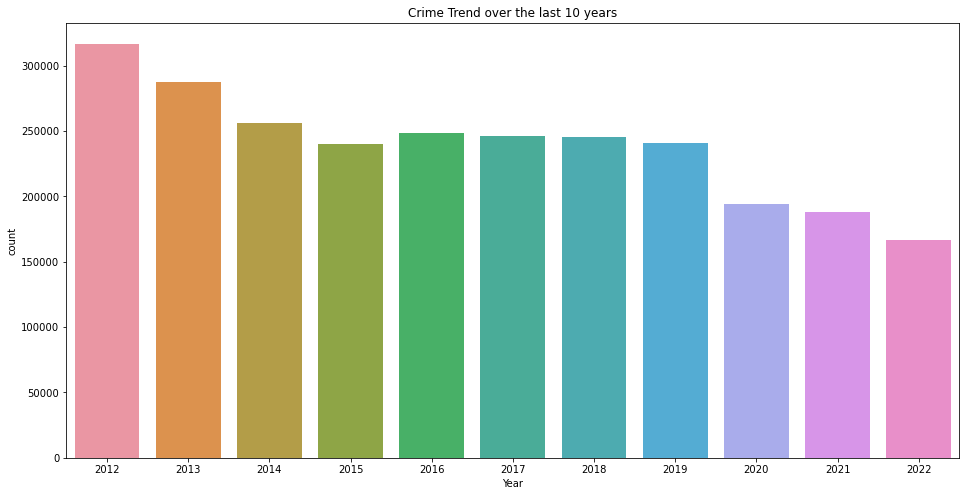

In [339]:
import seaborn as sns
plt.subplots(figsize=(16,8))
sns.barplot(data = year_crime_count_df, x = 'Year', y = 'count').set(title='Crime Trend over the last 10 years')

We can clearly conclude crime in 2012 was highest and may be strict policing helped to reduce it in coming years

#### Find out at which hour of the day crime is highest

In [340]:
from pyspark.sql.functions import hour
df_pyspark = df_pyspark.withColumn('hour',hour(df_pyspark.Date))

In [341]:
hour_crime_count_df = df_pyspark.groupBy('hour').count()
hour_crime_count_df = pd.DataFrame(hour_crime_count_df.orderBy('count',ascending=False).rdd.map(lambda e: e.asDict()).collect())
hour_crime_count_df

,hour,count
0,12,152269
1,19,148776
2,18,147846
3,15,143811
4,20,142676
5,17,140262
6,16,138893
7,0,138429
8,21,133790
9,14,132461


[Text(0.5, 1.0, 'Crimes over the last 10 years')]

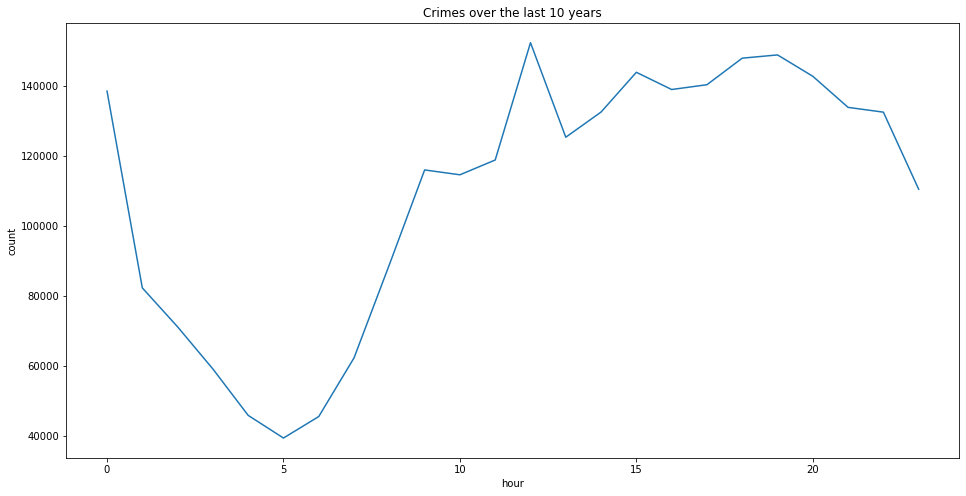

In [342]:
plt.subplots(figsize=(16,8))
sns.lineplot(data = hour_crime_count_df, x = 'hour', y = 'count').set(title='Crimes over the last 10 years')

We can clearly see that crime is highest during mid night around 12th hour of the day and during early morning low crime.

#### Find top ten crimes and present them as a bar chart.

In [343]:
from matplotlib import pyplot as plt

In [344]:
type_crime_count_df = df_pyspark.groupBy('Primary Type').count()
type_crime_count_df = pd.DataFrame(type_crime_count_df.orderBy('count',ascending=False).rdd.map(lambda e: e.asDict()).collect())
type_crime_count_df = type_crime_count_df.head(10)

[Text(0.5, 1.0, 'Top 10 Crimes over the last 10 years')]

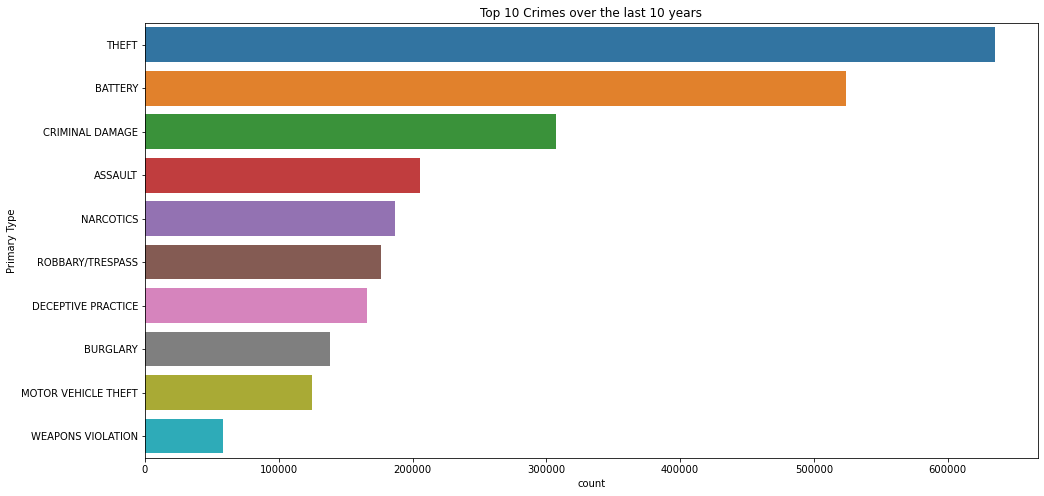

In [345]:
plt.subplots(figsize=(16,8))
sns.barplot(data = type_crime_count_df, x = 'count', y = 'Primary Type').set(title='Top 10 Crimes over the last 10 years')

Theft was the highest committed crime out of all 6 million reported crimes